In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

Load data, make corpus, tokenize, creater input sequences, split x(predictor) and y (label) to use training
* `total words` : 총 벡터 개수

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-19 17:54:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.217.15.112, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-19 17:54:55 (144 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]

3211


헉 갑자기 깨달음이 왔는데 Embedding layer에서 output dim은 이따가 100개 단어를 만들거니까 100이구나!!!
* `output_dim` in Embedding layer = # of predict words

Embedding layer parameters
* total_words : 들어가는 총 벡터 수
* output_dim : 몇 개 단어를 만들고 싶니(예측하고 싶니)?
* input_lenght : max sequence 길이 - 1 (라벨 빼고 트레이닝 데이터 길이)

LSTM layer parameters
* units : 얘는 아직 혼란스럽다. output_dim이랑 맞춰야 되는줄로만 알고 있었는데 아닌 모양.
* return_sequences : Multi layer LSTM 사용할 때 True로 설정해줘야 하는 값.

허걱 무의식적으로 compile에 loss를 `sparse_categorical_crossentropy`했더니 오류났다.(Invalid어쩌구Error). `categorical_crossentropy`랑 `sparse_categorical_crossentropu` 차이점 까먹어서ㅠㅠ 다시 공부하기

In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))# Your Embedding Layer
model.add(Bidirectional(LSTM(150, return_sequences=True))) # A LSTM Layer
model.add(Dropout(0.2)) # A dropout layer
#model.add(Bidirectional(LSTM(100)))# Another LSTM Layer
model.add(LSTM(100))
# l2 정규화 오랜만이당
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))# A Dense Layer including regularizers
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Pick a loss function and an optimizer
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [6]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 9s 11ms/step - loss: 7.3340 - accuracy: 0.0189
Epoch 2/100
484/484 [==============================] - 5s 11ms/step - loss: 6.4883 - accuracy: 0.0258
Epoch 3/100
484/484 [==============================] - 5s 11ms/step - loss: 6.4274 - accuracy: 0.0212
Epoch 4/100
484/484 [==============================] - 5s 11ms/step - loss: 6.3338 - accuracy: 0.0298
Epoch 5/100
484/484 [==============================] - 5s 11ms/step - loss: 6.2414 - accuracy: 0.0320
Epoch 6/100
484/484 [==============================] - 5s 11ms/step - loss: 6.1285 - accuracy: 0.0373
Epoch 7/100
484/484 [==============================] - 5s 11ms/step - loss: 6.0465 - accuracy: 0.0425
Epoch 8/100
484/484 [==============================] - 5s 11ms/step - loss: 5.9722 - accuracy: 0.0417
Epoch 9/100
484/484 [==============================] - 5s 11ms/step - loss: 5.8630 - accuracy: 0.0452
Epoch 10/100
484/484 [==============================] - 5s 11ms/step - loss: 5.788

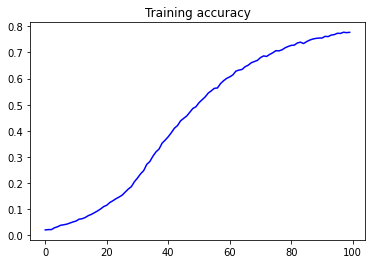

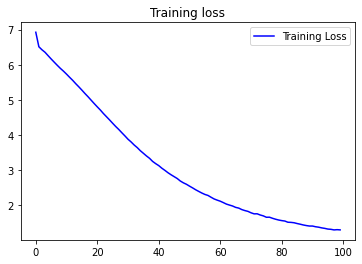

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope to seek and see me so poor time dear will halt know great store eyes end of injury of worms of date book dead woe pride loved to skill young away love thee in thee plea dote abuse me dead lie on me fair too much near aught in me now change thy time will show his power ' so dearer grief pride loved in thee out but done it is not i in love seen sort too short much cold ill cold ill green time tell of all love and i glutton be bevel now gone live up so


Help me Obi Wan Kenobi, you're my only hope to seek and see me so poor time dear will halt know great store eyes end of injury of worms of date book dead woe pride loved to skill young away love thee in thee plea dote abuse me dead lie on me fair too much near aught in me now change thy time will show his power ' so dearer grief pride loved in thee out but done it is not i in love seen sort too short much cold ill cold ill green time tell of all love and i glutton be bevel now gone live up so

어때!!!!